In [29]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import random

In [30]:
@njit
def calculate_epsilon(T):
    """
    args
        T: number of periods
    returns
        A list of T epsilon values
    """
    epsilon_values = []
    
    for i in range(T):
        theta = -((1/1000000) ** (1/T)) + 1
        epsilon = (1 - theta) ** i
        epsilon_values.append(epsilon)
    
    return epsilon_values

In [31]:
@njit
def demand(p1t,p2t):
    """
    args:
        p1t: price of agent 1
        p2t: price of agent 2
    returns:
        d: demand for given set of prices
    """
    if p1t<p2t:
        d = 1-p1t
    elif p1t==p2t:
        d = 0.5*(1-p1t)
    else:
        d = 0
    return d

In [32]:
@njit
def profit(p1t, p2t, prices):
    """
    args:
        p1t: index price of agent 1
        p2t: index price of agent 2
        prices: vector of prices
    returns:
        profit for agent
    """
    return prices[p1t] * demand(prices[p1t], prices[p2t])
 

In [33]:
@njit
def select_price_greedy(Q, current_s, p, epsilon):
    """Epsilon-greedy action selection.
    args:
        Q: Q-function
        current_s: current state
        p: price vector containing the possible prices
        epsilon: probability of selecting an action uniformly at random
    returns:
        the index of selected action
    """
    u = random.uniform(0,1)
    if u < epsilon:
        #return np.random.choice(p)
        random_index = np.random.choice(len(p))
        return random_index
    else:
        max_idx = np.argmax(Q[np.where(p == current_s)[0][0], :])
        #max_idx = np.argmax(Q[current_s, :])
        return max_idx

In [34]:
@njit
def Q_func(price_idx, current_state_idx, q_table, price_grid, delta, epsilon, alpha, it):
    """
    args
        price_idx: current price index
        current_state_idx: current state index
        q_table: q_table for 1 player
        price_grid: price grid
        delta: discount factor
        epsilon: probability of exploration
        alpha: step-size parameter
    returns:
        updated Q-table
    """
    prev_est = q_table[price_idx, current_state_idx]
    next_state_idx = select_price_greedy(q_table, price_grid[current_state_idx], price_grid, epsilon[it])
    max_Q = np.argmax(q_table[:, next_state_idx])
    new_est = profit(price_idx, current_state_idx, price_grid) + delta * profit(price_idx, next_state_idx, price_grid) + delta**2 * max_Q
    q_table[price_idx, current_state_idx] = (1 - alpha) * prev_est + alpha * new_est
    return next_state_idx
    



   

In [35]:
qtest = np.zeros((7, 7))
Q_func(2,5, qtest, np.linspace(0, 1, 7),0.95, calculate_epsilon(500000), 0.3, 1)
print(qtest)

/Users/mikkelEngelsted/opt/anaconda3/lib/python3.9/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'epsilon' of function 'Q_func'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../../var/folders/gr/gsfm7155227gh8vpmf4v3g840000gn/T/ipykernel_37123/3818313458.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.13 0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]


In [36]:
@njit
def simulation(alpha, delta, T, price_grid):
    # Initializing values
    epsilon = calculate_epsilon(T)
    k = len(price_grid)
    q1 = np.zeros((k, k))
    q2 = np.zeros((k, k))

    p_table = np.zeros((2, T))
    profits = np.zeros((2, T))
    avg_prof1 = []
    avg_prof2 = []

    i = 0
    j = 1
    t = 0
    # Setting prices for players in first 2 periods
    p_table[i,t] = int(np.random.choice(len(price_grid)))
    t += 1
    p_table[j,t] = int(np.random.choice(len(price_grid)))
    p_table[i,t] = p_table[i,t-1]
    # Updating profits for players in first 2 periods
    profits[i, t] = profit(int(p_table[i, t]), int(p_table[j, t]), price_grid)
    profits[j, t] = profit(int(p_table[j, t]), int(p_table[i, t]), price_grid)

    t += 1
    for t in range(t, T - 1):
        p_table[i, t] = Q_func(int(p_table[i, t - 2]), int(p_table[j, t - 2]), q1, price_grid, delta, epsilon, alpha, t)
        p_table[j, t] = p_table[j,t-1]
        # Updating other player's Q_table
        Q_func(int(p_table[j, t - 2]), int(p_table[i, t - 2]), q2, price_grid, delta, epsilon, alpha, t)
        profits[i, t] = profit(int(p_table[i, t]), int(p_table[j, t]), price_grid)
        profits[j, t] = profit(int(p_table[j, t]), int(p_table[i, t]), price_grid)
        if t % 1000 == 0:
            profitability1 = np.sum(profits[i, (t - 1000):t]) / 1000
            avg_prof1.append(profitability1)
            profitability2 = np.sum(profits[j, (t - 1000):t]) / 1000
            avg_prof2.append(profitability2)

        #Changing between players
        tmp = i
        i = j
        j = tmp

    return p_table, q1, q2, profits, avg_prof1, avg_prof2




In [37]:
a,b,c,d,e,f = simulation(0.3, 0.95, 500000, np.linspace(0, 1, 7))


In [38]:
print(a[0, 1:100])
print(a[1, 1:100])
#print("q1: \n", b)
#print("q2: \n", c)

[5. 6. 6. 2. 2. 3. 3. 2. 2. 2. 2. 6. 6. 2. 2. 4. 4. 1. 1. 4. 4. 4. 4. 5.
 5. 0. 0. 6. 6. 5. 5. 3. 3. 3. 3. 0. 0. 2. 2. 5. 5. 3. 3. 4. 4. 0. 0. 2.
 2. 1. 1. 5. 5. 6. 6. 6. 6. 3. 3. 0. 0. 4. 4. 6. 6. 6. 6. 0. 0. 2. 2. 5.
 5. 2. 2. 0. 0. 1. 1. 2. 2. 4. 4. 5. 5. 4. 4. 1. 1. 2. 2. 2. 2. 1. 1. 0.
 0. 0. 0.]
[1. 1. 4. 4. 0. 0. 0. 0. 4. 4. 5. 5. 3. 3. 1. 1. 0. 0. 5. 5. 3. 3. 3. 3.
 6. 6. 2. 2. 1. 1. 4. 4. 6. 6. 4. 4. 3. 3. 6. 6. 1. 1. 6. 6. 6. 6. 5. 5.
 6. 6. 0. 0. 6. 6. 1. 1. 6. 6. 0. 0. 1. 1. 6. 6. 1. 1. 0. 0. 3. 3. 0. 0.
 6. 6. 2. 2. 5. 5. 0. 0. 2. 2. 4. 4. 6. 6. 6. 6. 0. 0. 0. 0. 6. 6. 2. 2.
 3. 3. 3.]


In [39]:
print(d[0,:50])
print(d[1,:50])
print(e)
print(f)

[0.         0.         0.         0.         0.22222222 0.
 0.         0.         0.         0.22222222 0.22222222 0.22222222
 0.         0.         0.22222222 0.         0.         0.
 0.         0.13888889 0.22222222 0.         0.         0.
 0.         0.13888889 0.         0.         0.         0.
 0.         0.         0.25       0.25       0.25       0.25
 0.         0.         0.22222222 0.22222222 0.13888889 0.
 0.         0.25       0.22222222 0.22222222 0.         0.
 0.22222222 0.22222222]
[0.         0.13888889 0.13888889 0.22222222 0.         0.
 0.         0.         0.         0.         0.         0.
 0.13888889 0.25       0.         0.13888889 0.13888889 0.
 0.         0.         0.         0.25       0.25       0.25
 0.25       0.         0.         0.         0.22222222 0.13888889
 0.13888889 0.22222222 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.13888889
 0.13888889 0.         0.         0.         0.         0.
 0. 

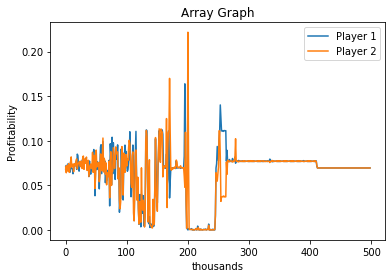

In [40]:
x_values = range(len(e))

# Plot the array as a line graph
plt.plot(x_values, e)
plt.plot(x_values, f)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

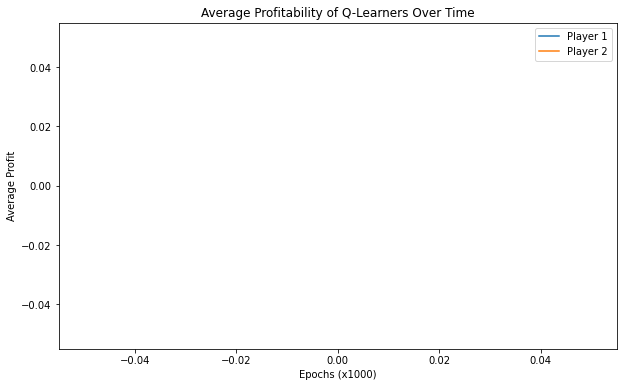

[[4 6 2 3 1 3 6 4 0 3]
 [3 0 3 3 6 3 0 3 0 4]]
[[0.         0.         0.22222222 0.125      0.13888889 0.125
  0.         0.         0.         0.25      ]
 [0.         0.         0.         0.125      0.         0.125
  0.         0.25       0.         0.        ]]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import random

@njit
def calculate_epsilon(T):
    epsilon_values = np.empty(T)
    for i in range(T):
        epsilon_values[i] = 1 - ((i + 1) / T)
    return epsilon_values

@njit
def demand(p1t, p2t):
    if p1t < p2t:
        d = 1 - p1t
    elif p1t == p2t:
        d = 0.5 * (1 - p1t)
    else:
        d = 0
    return d

@njit
def profit(p1t, p2t, prices):
    return prices[p1t] * demand(prices[p1t], prices[p2t])

@njit
def select_price_greedy(Q, current_s, p, epsilon):
    u = random.uniform(0, 1)
    if u < epsilon:
        random_index = np.random.choice(len(p))
        return random_index
    else:
        max_idx = np.argmax(Q[np.where(p == current_s)[0][0], :])
        return max_idx

@njit
def Q_func(price_idx, current_state_idx, q_table, price_grid, delta, epsilon, alpha):
    immediate_reward = profit(price_idx, current_state_idx, price_grid)
    next_state_idx = select_price_greedy(q_table, price_grid[current_state_idx], price_grid, epsilon)
    max_future_q = np.max(q_table[:, next_state_idx])
    q_table[price_idx, current_state_idx] += alpha * (immediate_reward + delta * max_future_q - q_table[price_idx, current_state_idx])
    return q_table


@njit
def simulation(alpha, delta, T, price_grid):
    epsilon = calculate_epsilon(T)
    k = len(price_grid)
    q1 = np.zeros((k, k))
    q2 = np.zeros((k, k))

    p_table = np.zeros((2, T), dtype=np.int64)
    profits = np.zeros((2, T))
    avg_prof1 = []
    avg_prof2 = []

    # Initialize prices randomly
    p_table[:, 0] = np.random.choice(k, 2)

    for t in range(1, T):
        current_epsilon = epsilon[t]
        # Update Q-tables and select next prices
        for i in range(2):
            opponent_idx = 1 - i
            q_table = q1 if i == 0 else q2
            current_state_idx, opponent_state_idx = p_table[i, t-1], p_table[opponent_idx, t-1]
            q_table = Q_func(current_state_idx, opponent_state_idx, q_table, price_grid, delta, current_epsilon, alpha)
            p_table[i, t] = select_price_greedy(q_table, price_grid[current_state_idx], price_grid, current_epsilon)

        # Calculate profits
        profits[0, t] = profit(p_table[0, t], p_table[1, t], price_grid)
        profits[1, t] = profit(p_table[1, t], p_table[0, t], price_grid)
        

        # Update average profits every 1000 iterations
        if t % 1000 == 0:
            avg_prof1.append(np.mean(profits[0, max(0, t-1000):t]))
            avg_prof2.append(np.mean(profits[1, max(0, t-1000):t]))

    return p_table, q1, q2, profits, avg_prof1, avg_prof2

# Simulation parameters
alpha = 0.1
delta = 0.95
T = 10
price_grid = np.linspace(0, 1, 7)

# Run the simulation
a, b, c, d, e, f = simulation(alpha, delta, T, price_grid)

# Plotting
plt.figure(figsize=(10, 6))
x_values = np.arange(len(e))
plt.plot(x_values, e, label='Player 1')
plt.plot(x_values, f, label='Player 2')
plt.xlabel('Epochs (x1000)')
plt.ylabel('Average Profit')
plt.title('Average Profitability of Q-Learners Over Time')
plt.legend()
plt.show()

print(a)
print(d)


In [24]:
num_calcs = int(T/1000-1)
summed_avg_profitabilities = np.zeros(num_calcs)

for n in range(0, 10):
    p_table, q1, q2, profits, avg_profs1, avg_profs2 = simulation(alpha, delta, T, price_grid)
    per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
    summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)
    
avg_avg_profitabilities = np.divide(summed_avg_profitabilities, 10)
    

[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.02222222 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.02222222 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0. 

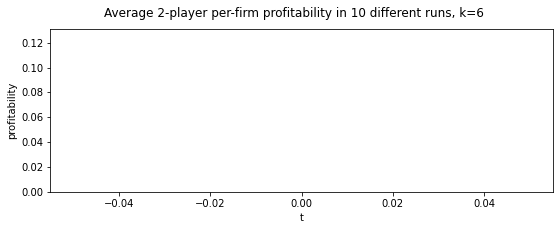

In [46]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(10, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, T, num_calcs)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.plot(xs, avg_avg_profitabilities, color="steelblue", label = "avg. profitability")


In [72]:
q1

array([[4.1980796 , 4.22027227, 4.26306102, 4.43491092, 4.4406674 ,
        4.41929135, 4.41397459],
       [4.17657188, 4.2408314 , 4.39069359, 4.56296749, 4.55629819,
        4.55696341, 4.55796852],
       [4.22299377, 4.23925016, 4.36043966, 4.66942814, 4.63186482,
        4.61511101, 4.63913053],
       [4.42614363, 4.42137713, 4.40675954, 4.59731775, 4.71450976,
        4.7016589 , 4.68595673],
       [4.39691795, 4.41289705, 4.39741529, 4.47878427, 4.57506341,
        4.67387762, 4.65817896],
       [4.39299815, 4.4287836 , 4.41169214, 4.47878427, 4.46450976,
        4.5188215 , 4.57484562],
       [4.42277881, 4.42230124, 4.40367854, 4.47878421, 4.46657595,
        4.4516589 , 4.43595673]])

In [73]:
q2

array([[4.29221448, 4.292816  , 4.33673945, 4.41984103, 4.35487581,
        4.36026518, 4.3791724 ],
       [4.29567758, 4.35199279, 4.46785841, 4.55704788, 4.52444625,
        4.53766463, 4.52347535],
       [4.27328017, 4.24008853, 4.41038243, 4.63008012, 4.61970687,
        4.61592021, 4.59012681],
       [4.36661742, 4.36394213, 4.36518407, 4.56943654, 4.68283972,
        4.66614731, 4.64857611],
       [4.37182538, 4.37640703, 4.38024114, 4.44869027, 4.54394568,
        4.63836953, 4.62079834],
       [4.37183341, 4.36927512, 4.36995036, 4.44869773, 4.43283972,
        4.48559167, 4.537756  ],
       [4.37820306, 4.38184855, 4.38469266, 4.44869773, 4.43283994,
        4.41614731, 4.39857615]])

In [78]:
qtest = np.zeros((7, 7))
eps = calculate_epsilon(500000)
Q_func(5,4, qtest, np.linspace(0, 1, 7),0.95, eps[490000], 0.3)
print(qtest)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


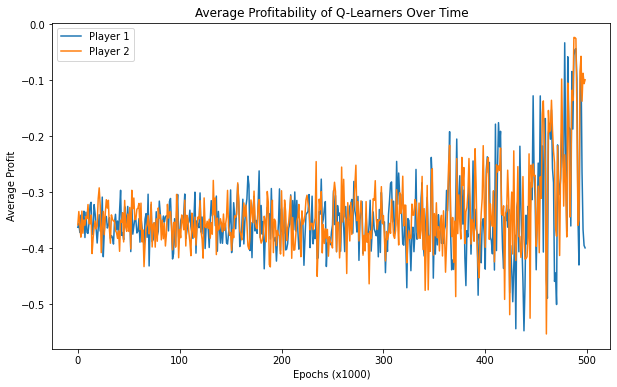